In [56]:
from pathlib import Path
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import nibabel as nib
from tqdm import tqdm
from EM import ExpectationMaximization
import matplotlib.pyplot as plt
import SimpleITK as sitk

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
pd_val_path = Path().resolve() / 'proc_data/Validation_Set/'
pd_train_path = Path().resolve() / 'proc_data/Training_Set/'
val_path = Path().resolve() / 'data/Validation_Set/'
train_path = Path().resolve() / 'data/Training_Set/'


# MAIN

In [3]:
def extract_pixels(im_list:list, mask:np.ndarray):
    """extract pixels from a list of images based on a mask

    Args:
        im_list (list): list of images
        mask (np.ndarray): mask to extract the pixels

    Returns:
        np.ndarray: extracted pixels flattened
    """
    ims_flat = [x[mask!=0] for x in im_list]
    extracted = np.stack(ims_flat).T
    extracted = extracted.reshape(extracted.shape[0], -1)
    
    return extracted

def reindexing(alphas:np.ndarray, means:list, covs:list):
    """Reindexing function designed to avoid the probelm of the order of tissue ordering after kmeans initialization

    Args:
        alphas (np.ndarray): alpha values
        means (list): list of means
        covs (list): list of covariances

    Returns:
        same as input: same three inputs but reordered
    """

    means_np = np.vstack(means) #turn means into numpy array
    covs_np = np.vstack(covs) #turn covs into numpy array
    idx = np.argsort(means_np[:,0]) #get indexing for sorting
    means_np = means_np[idx] #reorder
    covs_np = covs_np[idx] #reorder
    alphas = alphas[idx] #reorder
    lut = np.arange(0,3)
    lut[[1,2]] = lut[[2,1]]
    means_np = means_np[lut]
    covs_np = covs_np[lut]
    alphas = alphas[lut]
    means = [means_np[i] for i in range(3)] #restore
    covs = [covs_np[i] for i in range(3)] #restore
    
    return alphas, means, covs

def init_kmeans(extracted:np.ndarray, n_components:int):
    """performs kmenas to extracted pixles

    Args:
        extracted (array): extracted pixels
        n_components (in): number of components

    Returns:
        array, list, list: alphas, means and covariances
    """
    kmeans = KMeans(n_clusters=n_components) #3 tissue types
    labels = kmeans.fit_predict(extracted) #predict labels
    centers = kmeans.cluster_centers_ #predict centers
    alphas = np.ones(n_components)/n_components #init alphas
    
    for i, cluster in enumerate(np.unique(labels)):
        alphas[i] = np.sum(labels==cluster)/labels.shape[0] #update alphas
    
    means = []
    covs = []
    
    for cluster in range(n_components):
        means.append(centers[cluster])
        covs.append(np.cov(extracted[labels==cluster].T))
        
    return reindexing(alphas, means, covs)

def E_step(extracted, n_components, alphas, means, covs):
    """expectation step of em algorithm

    Args:
        extracted (array): pixels to be used for the intensity model
        n_components (int): number of clusters
        alphas (array): alphas of the EM model
        means (array): means fo the clusters
        covs (array): covariance matrix of the clusters

    Returns:
        arrays: pk and wk according to the EM algorithm
    """
    pk = np.zeros((extracted.shape[0], n_components))
    for cluster in range(n_components):
        pk[:,cluster] = alphas[cluster] * multivariate_normal.pdf(extracted, mean=means[cluster], cov=covs[cluster]) #weigted pk calculation
    wk = np.zeros((extracted.shape[0], n_components))
    for cluster in range(n_components):
        wk[:,cluster] = pk[:,cluster]/np.sum(pk, axis=1) #wk calculation
    
    return pk, wk

def M_step(wk, n_components, extracted, means, covs):
    """maximisation step of em algorithm

    Args:
        wk (array): wk value as descibed in the EM algorithm
        n_components (int): number of components in clustering
        extracted (array): extracted pixels
        means (list): list of means
        covs (list): list of covariances

    Returns:
        array, list and list: parameters of EM algorithm
    """
    nk = np.sum(wk, axis=0) #nk calculation
    alphas = nk/wk.shape[0] #alphas calculation
    for cluster in range(n_components):
        means[cluster] = np.sum(wk[:,cluster][:,np.newaxis] * extracted, axis=0)/nk[cluster]
    for cluster in range(n_components):
        covs[cluster] = (wk[:,cluster][:,np.newaxis]*(extracted-means[cluster])).T @ (extracted-means[cluster])/nk[cluster]
    return alphas, means, covs

def log_likehood(pk):
    """returns log likehood of the model

    Args:
        pk (array): pk as descibed in the EM algorithm

    Returns:
        float: value of the log likehood
    """
    return np.log(pk.sum(axis=1)).sum()

def ll_diff(pk, prev_log, new_log):
    """difference between log likehoods

    Args:
        pk (array): pk as descibed in the EM algorithm
        prev_log (float): previous log likehood
        new_log (float): new log likehood

    Returns:
        float: absolute difference between log likehoods
    """
    prev_log = new_log
    new_log = log_likehood(pk)
    return abs(new_log - prev_log), prev_log, new_log

def get_seg(im_list, wk, mask):
    """given wk returns final segmentation

    Args:
        wk (array): wk array of EM algorithm
    """
    labels = np.argmax(wk, axis=1) + 1 #get labels
    seg_mask = np.zeros(im_list[0].shape) #create empy mask
    seg_mask[mask!=0] = labels #assign pixels to empy mask
    
    return seg_mask

In [57]:
def EM(im_list, mask, init_method, error = 10e-6, iter_num = 500 ):
    #first we extract the piels under the mask
    extracted = extract_pixels(im_list, mask)

    #select initalisation method
    if init_method == 'kmeans':
        alphas, means, covs = init_kmeans(extracted, n_components=3)

    #Stopping criteria
    prev_log = 0
    new_log = 2
    
    #start loop
    diffs = []
    for i in tqdm(range(iter_num), total=iter_num, desc='EM'):
        #EM step
        pk, wk = E_step(extracted, n_components=3, alphas=alphas, means=means, covs=covs)
        #M step
        alphas, means, covs = M_step(wk, n_components=3, extracted=extracted, means=means, covs=covs)
        #ll calculation
        diff, prev_log, new_log = ll_diff(pk, prev_log, new_log)
        diffs.append(diff)
        if diff < error: #check if error is small enough
            break

    #final segmentation
    seg_mask = get_seg(im_list, wk, mask)
    
    return seg_mask, diffs

def plot_3_images(img1, img2, img3, title1='1', title2='2', title3='3', cmap='gray'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2)
    ax3.imshow(img3, cmap=cmap)
    ax3.set_title(title3)
    ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
    plt.show()

def dice_score(img1,img2):
    """Dice score

    Args:
        img1 (3D array): FIrst image to compute Dice from
        img2 (3D array): FIrst image to compute Dice from

    Returns:
        float: Dice score value
    """
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
    return dice

def convert_nda_to_itk(nda: np.ndarray, itk_image: sitk.Image):
    """From a numpy array, get an itk image object, copying information
    from an existing one. It switches the z-axis from last to first position.

    Args:
        nda (np.ndarray): 3D image array
        itk_image (sitk.Image): Image object to copy info from

    Returns:
        new_itk_image (sitk.Image): New Image object
    """
    new_itk_image = sitk.GetImageFromArray(np.moveaxis(nda, -1, 0))
    new_itk_image.SetOrigin(itk_image.GetOrigin())
    new_itk_image.SetSpacing(itk_image.GetSpacing())
    new_itk_image.CopyInformation(itk_image)
    return new_itk_image

def convert_itk_to_nda(itk_image: sitk.Image):
    """From an itk Image object, get a numpy array. It moves the first z-axis
    to the last position (np.ndarray convention).

    Args:
        itk_image (sitk.Image): Image object to convert

    Returns:
        result (np.ndarray): Converted nda image
    """
    return np.moveaxis(sitk.GetArrayFromImage(itk_image), 0, -1)

In [64]:
for val_set in pd_val_path.iterdir():
    if val_set.is_dir():
        print(val_set.name)

IBSR_11
IBSR_12
IBSR_13
IBSR_17
IBSR_14


In [65]:
img =  nib.load(str(val_path/f'{val_set.name}/{val_set.name}.nii.gz')).get_fdata()
mask =  nib.load(str(val_path/f'{val_set.name}/{val_set.name}_seg.nii.gz')).get_fdata()
em_pred, diffs = EM([img], mask, init_method='kmeans')

EM:  64%|██████▍   | 320/500 [01:58<01:06,  2.70it/s]


{'CSF': 0.2850237519793316, 'WM': 0.9012901739125828, 'GM': 0.7883195998589246}


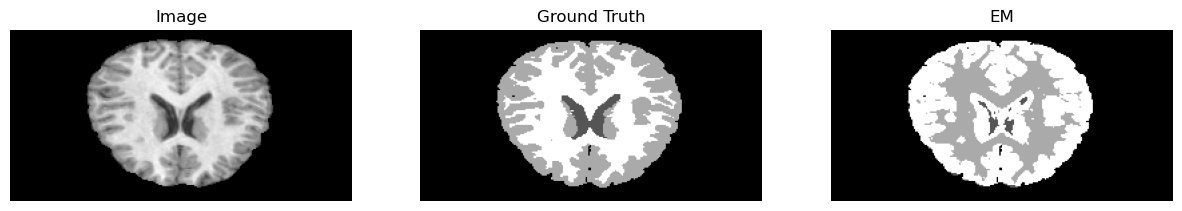

In [66]:
print(ExpectationMaximization.compute_dice(mask, em_pred, map_dict={1:1, 2:3, 3:2}))
# for i in range(3):
#     print(dice_score(mask == (i+1), em_pred == (i+1)))
# # plt.imshow(em_pred[:,:,150, 0].T, cmap='gray')
slice = 150
plot_3_images(img[:,:,slice, 0].T, mask[:,:,slice, 0].T, em_pred[:,:,slice,0].T, 
                title1='Image', title2='Ground Truth', title3='EM')

EM:  64%|██████▍   | 320/500 [02:49<01:35,  1.89it/s]


{'CSF': 0.2850237519793316, 'WM': 0.9012901739125828, 'GM': 0.7883195998589246}


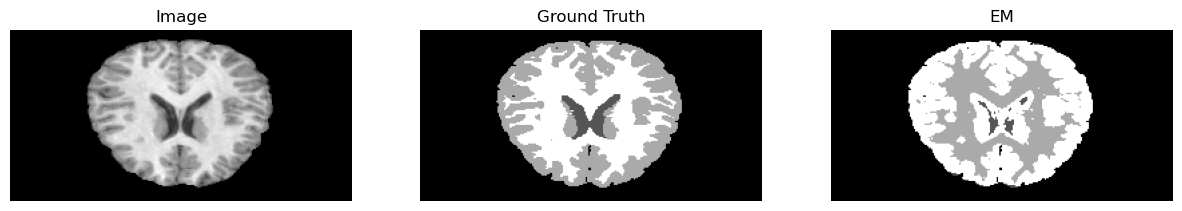

In [67]:
val_img = convert_itk_to_nda(sitk.ReadImage(str(val_path/f'{val_set.name}/{val_set.name}.nii.gz')))
# # val_img = sitk.Cast(val_img, sitk.sitkFloat64)
val_segmentation = convert_itk_to_nda(sitk.ReadImage(str(val_path/f'{val_set.name}/{val_set.name}_seg.nii.gz')))
em_pred, diffs = EM([val_img], val_segmentation, init_method='kmeans')

print(ExpectationMaximization.compute_dice(val_segmentation, em_pred, map_dict={1:1, 2:3, 3:2}))
slice = 150
plot_3_images(val_img[:,:,slice], val_segmentation[:,:,slice], em_pred[:,:,slice], 
                title1='Image', title2='Ground Truth', title3='EM')

In [68]:
diffs

[4548327.817282301,
 35439.15440161526,
 13224.40583379753,
 7418.470174412243,
 4904.0911332322285,
 3509.358420426026,
 2616.0610944563523,
 1996.2013174379244,
 1551.8126024259254,
 1233.321447934024,
 1009.1177145922557,
 854.8064560862258,
 750.3959226207808,
 679.9848990729079,
 631.6739243753254,
 597.1082547483966,
 570.7498730551451,
 549.1070640655234,
 530.0732470694929,
 512.4282405963168,
 495.4935531169176,
 478.9087811606005,
 462.4934080392122,
 446.1647559357807,
 429.890966238454,
 413.6650119153783,
 397.4910242315382,
 381.3775989646092,
 365.3349820720032,
 349.37435133289546,
 333.50815274287015,
 317.7508974028751,
 302.1200588028878,
 286.6368972947821,
 271.3269960936159,
 256.22051423601806,
 241.3520894497633,
 226.76037397421896,
 212.48719118069857,
 198.57647441513836,
 185.07291224971414,
 172.02047317940742,
 159.4609371908009,
 147.43235468585044,
 135.96784484293312,
 125.09439055994153,
 114.83213161211461,
 105.19381989631802,
 96.18469792418182,
 87

{'CSF': 0.0693383847352947, 'WM': 0.5584173766519933, 'GM': 0.8817258898321442}


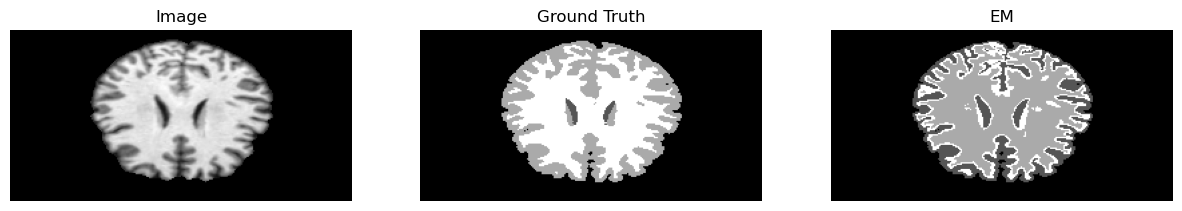

In [ ]:
img = nib.load(str(val_path.parent/'other_imgs/1003.nii.gz')).get_fdata()
mask = nib.load(str(val_path.parent/'other_imgs/1003_3C.nii.gz')).get_fdata()
em_pred, diffs = EM([img], mask, init_method='kmeans')
print(ExpectationMaximization.compute_dice(mask, em_pred, map_dict={1:3, 2:2, 3:1}))
print(diffs)

In [26]:
em_pred.shape

(256, 316, 256)

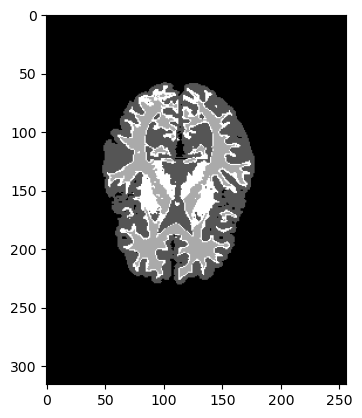

In [29]:
plt.imshow(em_pred[:,:,150].T, cmap='gray')